In [1]:
!pip install -q rasterio  # -q is for quiet installation, non-verbose

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 86.9 MB/s eta 0:00:00:00:0100:01


## Imports

In [2]:
import os
import torch
import numpy as np
import rasterio
import glob
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Parameters

In [18]:
# Paths and settings
BASE_PATH      = '/kaggle/input/sentinel2-crop-mapping'
H5_PATH        = '/kaggle/working/tiles_2016-18_uint8.h5'
REGIONS        = ['lombardia', 'lombardia2']
YEARS          = ['data2016', 'data2017', 'data2018']
NUM_TIMESTEPS  = 32
NUM_CLASSES    = 20
BATCH_SIZE     = 64
NUM_WORKERS    = 4
PIN_MEMORY     = True
LR             = 0.01
NUM_EPOCHS     = 15
DEVICE         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset Preprocessing and Loading

In [ ]:
# 1) Preprocess: pack all tiles into one HDF5

if not os.path.exists(H5_PATH):
    print(f"Creating HDF5 archive at {H5_PATH}...")

    # gather tile directories
    tile_dirs = []
    for reg in REGIONS:
        for yr in YEARS:
            tile_dirs += glob.glob(os.path.join(BASE_PATH, reg, yr, '*'))
    N = len(tile_dirs)

    with h5py.File(H5_PATH, 'w') as hf:
        imgs = hf.create_dataset(
            'images',
            shape=(N, 9*NUM_TIMESTEPS, 48, 48),
            dtype='uint8',
            chunks=(1, 9*NUM_TIMESTEPS, 48, 48),
            compression='lzf')
        masks = hf.create_dataset(
            'masks',
            shape=(N, 48, 48),
            dtype='uint8',
            chunks=(1, 48, 48),
            compression='lzf')

        write_idx = 0
        for td in tqdm(tile_dirs, desc='Writing HDF5'):
            if not os.path.isdir(td):
                continue

            # list & sort your 32 multispectral .tifs
            tifs = sorted([
                f for f in os.listdir(td)
                if f.endswith('.tif') and '_MSAVI' not in f and f != 'y.tif'
            ])[:NUM_TIMESTEPS]

            # skip if too few files
            if len(tifs) < NUM_TIMESTEPS:
                continue

            # load & stack
            stack = []
            for f in tifs:
                with rasterio.open(os.path.join(td, f)) as src:
                    stack.append(src.read().astype(np.float32))
            img = np.stack(stack, axis=1).reshape(-1, 48, 48)

            # quantize
            img_min, img_max = img.min(), img.max()
            img_q = ((img - img_min) / (img_max - img_min) * 255.0)\
                      .round().astype(np.uint8)

            # load mask
            with rasterio.open(os.path.join(td, 'y.tif')) as src:
                mask = src.read(1).astype(np.uint8)
            mask[mask >= 20] = 255

            # write into HDF5
            imgs[write_idx]  = img_q
            masks[write_idx] = mask
            write_idx += 1

        # after the loop, resize to actual count
        hf['images'].resize(write_idx, axis=0)
        hf['masks'].resize(write_idx, axis=0)

    print("HDF5 archive created.") 

Creating HDF5 archive at /kaggle/working/tiles_2016-18_uint8.h5...


Writing HDF5:  91%|█████████ | 18081/19969 [2:25:58<15:10,  2.07it/s]  

In [7]:
# 2) Dataset: lazy-load from HDF5 and rescale
class HDF5SentinelDataset(torch.utils.data.Dataset):
    def __init__(self, h5_path, indices, transform=None):
        self.hf      = h5py.File(h5_path, 'r')
        self.imgs    = self.hf['images']
        self.masks   = self.hf['masks']
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i   = self.indices[idx]
        img = torch.from_numpy(self.imgs[i]).float() / 255.0
        msk = torch.from_numpy(self.masks[i]).long()
        if self.transform:
            img, msk = self.transform(img, msk)
        return img, msk

In [8]:
# 3) Prepare train/val splits and dataloaders
with h5py.File(H5_PATH, 'r') as hf:
    total = hf['images'].shape[0]

print(total)
all_indices = list(range(total))
train_idx, val_idx = train_test_split(all_indices, test_size=0.2, random_state=42)

train_ds = HDF5SentinelDataset(H5_PATH, train_idx)
val_ds   = HDF5SentinelDataset(H5_PATH, val_idx)

print(f'Length of Train dataset: {len(train_ds)}')
print(f'Length of Val dataset: {len(val_ds)}')

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

19968
Length of Train dataset: 15974
Length of Val dataset: 3994


-> Shape of the input is (9*32, 48, 48) and of output is (48, 48) with batch size of 8.

Train Sample:
x_train shape: torch.Size([288, 48, 48])
y_train shape: torch.Size([48, 48])
x_train dtype: torch.float32
y_train unique labels: tensor([ 4,  9, 12, 17])


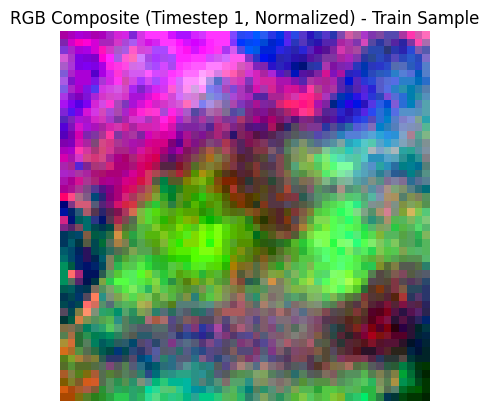

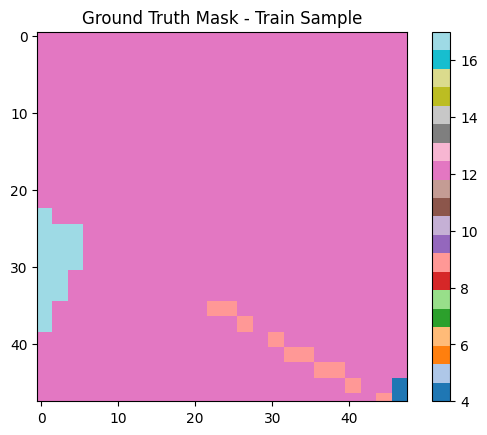


Validation Sample:
x_val shape: torch.Size([288, 48, 48])
y_val shape: torch.Size([48, 48])
x_val dtype: torch.float32
y_val unique labels: tensor([  2,   6,   7,   9,  14,  15,  17, 255])


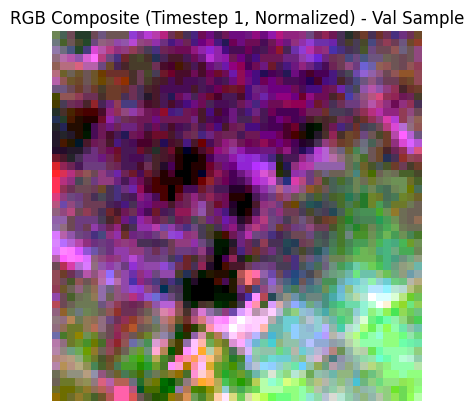

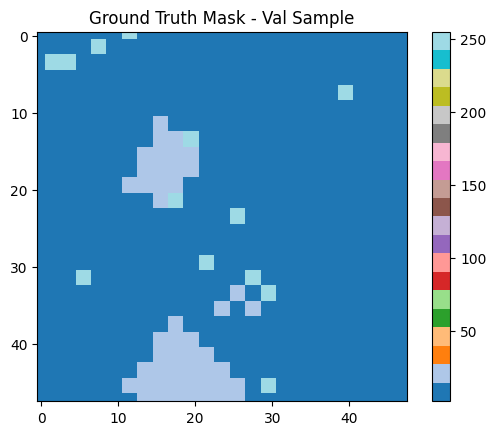

In [9]:
# Visualizing the images (rgb composite for multispectral input)
def normalize_band(band):
    """Contrast stretch to 2–98 percentile"""
    p2, p98 = np.percentile(band, (2, 98))
    return np.clip((band - p2) / (p98 - p2), 0, 1)
    

# Print from train dataset
x_train, y_train = train_ds[0]
print("Train Sample:")
print(f"x_train shape: {x_train.shape}")  # Expected: (288, 48, 48)
print(f"y_train shape: {y_train.shape}")  # Expected: (48, 48)")
print(f"x_train dtype: {x_train.dtype}")
print(f"y_train unique labels: {torch.unique(y_train)}")  # Sanity check

# Extract bands 4, 3, 2 from timestep 1
b2 = 1   # Blue
b3 = 2   # Green
b4 = 3   # Red

rgb = x_train[[b4, b3, b2]]  # Shape: (3, 48, 48)

r = normalize_band(rgb[0].numpy())
g = normalize_band(rgb[1].numpy())
b = normalize_band(rgb[2].numpy())

rgb_normalized = np.stack([r, g, b], axis=-1)

# Show corrected image
plt.imshow(rgb_normalized)
plt.title("RGB Composite (Timestep 1, Normalized) - Train Sample")
plt.axis("off")
plt.show()

# Show mask
plt.imshow(y_train, cmap='tab20')
plt.title("Ground Truth Mask - Train Sample")
plt.colorbar()
plt.show()



# Print from val dataset
x_val, y_val = val_ds[0]
print("\nValidation Sample:")
print(f"x_val shape: {x_val.shape}")  # Expected: (288, 48, 48)
print(f"y_val shape: {y_val.shape}")  # Expected: (48, 48)")
print(f"x_val dtype: {x_val.dtype}")
print(f"y_val unique labels: {torch.unique(y_val)}")


# For Val data
rgb = x_val[[b4, b3, b2]]  # Shape: (3, 48, 48)

r = normalize_band(rgb[0].numpy())
g = normalize_band(rgb[1].numpy())
b = normalize_band(rgb[2].numpy())

rgb_normalized = np.stack([r, g, b], axis=-1)

# Show corrected image
plt.imshow(rgb_normalized)
plt.title("RGB Composite (Timestep 1, Normalized) - Val Sample")
plt.axis("off")
plt.show()

# Show mask
plt.imshow(y_val, cmap='tab20')
plt.title("Ground Truth Mask - Val Sample")
plt.colorbar()
plt.show()

## 2D-CNN Model 

In [20]:
in_channels = 9 * NUM_TIMESTEPS

model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels, 64, kernel_size=5, stride=2, padding=2),  # → 64×24×24
    torch.nn.ReLU(inplace=True),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),                           # → 64×12×12

    torch.nn.Conv2d(64, 192, kernel_size=3, padding=1),                    # → 192×12×12
    torch.nn.ReLU(inplace=True),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),                           # → 192×6×6

    torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),                   # → 384×6×6
    torch.nn.ReLU(inplace=True),

    torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),                   # → 256×6×6
    torch.nn.ReLU(inplace=True),

    torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),                   # → 256×6×6
    torch.nn.ReLU(inplace=True),

    torch.nn.Conv2d(256, NUM_CLASSES, kernel_size=1),                      # → 20×6×6
    torch.nn.Upsample(size=(48, 48), mode='bilinear', align_corners=False) # → 20×48×48
).to(DEVICE)

print(model)

Sequential(
  (0): Conv2d(288, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 20, kernel_size=(1, 1), stride=(1, 1))
  (13): Upsample(size=(48, 48), mode='bilinear')
)


-> The FC layers are removed and instead a Conv2D layer is used since we want the 2D segmentation map and FC layers flatten the 2d in 1d.

In [11]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

In [12]:
@torch.no_grad()
def pixel_accuracy(out, target):
    """
    Calculating pixel-wise accuracy by comparing the predicted class per pixel with the 
    ground truth and compute how many pixels were correctly classified.
    
    pred: tensor of shape (B, C, H, W) - raw logits
    target: tensor of shape (B, H, W) - class labels 
    """
    preds = out.argmax(dim=1)
    return (preds == target).float().mean().item()

## Training Loop

In [13]:
# 5) Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    t_loss, t_acc = 0.0, 0.0
    for x, y in tqdm(train_loader, desc=f'Epoch {epoch} Training'):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_acc  += pixel_accuracy(out, y)
    t_loss /= len(train_loader)
    t_acc  /= len(train_loader)

    train_losses.append(t_loss)
    train_accuracies.append(t_acc)

    # Validation loop
    model.eval()
    v_loss, v_acc = 0.0, 0.0
    for x, y in tqdm(val_loader, desc=f'Epoch {epoch} Validating'):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = criterion(out, y)
        v_loss += loss.item()
        v_acc  += pixel_accuracy(out, y)
    v_loss /= len(val_loader)
    v_acc  /= len(val_loader)

    val_losses.append(v_loss)
    val_accuracies.append(v_acc)

    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Train Loss: {t_loss:.4f}, Acc: {t_acc:.4f} | "
          f"Val Loss: {v_loss:.4f}, Acc: {v_acc:.4f}")


Epoch 1 Validating: 100%|██████████| 63/63 [00:13<00:00,  4.81it/s]


Epoch 1/15 | Train Loss: 2.6708, Acc: 0.2239 | Val Loss: 2.1821, Acc: 0.2284


Epoch 2 Validating: 100%|██████████| 63/63 [00:12<00:00,  4.95it/s]


Epoch 2/15 | Train Loss: 2.1681, Acc: 0.2284 | Val Loss: 2.1578, Acc: 0.2365


Epoch 3 Validating: 100%|██████████| 63/63 [00:12<00:00,  5.13it/s]


Epoch 3/15 | Train Loss: 2.1222, Acc: 0.2674 | Val Loss: 1.9826, Acc: 0.3867


Epoch 4 Validating: 100%|██████████| 63/63 [00:12<00:00,  5.13it/s]


Epoch 4/15 | Train Loss: 1.8860, Acc: 0.3883 | Val Loss: 1.8539, Acc: 0.3901


Epoch 5 Validating: 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]


Epoch 5/15 | Train Loss: 1.8368, Acc: 0.3910 | Val Loss: 1.8283, Acc: 0.3899


Epoch 6 Validating: 100%|██████████| 63/63 [00:12<00:00,  5.10it/s]


Epoch 6/15 | Train Loss: 1.8248, Acc: 0.3908 | Val Loss: 1.8031, Acc: 0.3926


Epoch 7 Validating: 100%|██████████| 63/63 [00:12<00:00,  5.08it/s]


Epoch 7/15 | Train Loss: 1.8118, Acc: 0.3917 | Val Loss: 1.7974, Acc: 0.3913


Epoch 8 Validating: 100%|██████████| 63/63 [00:12<00:00,  4.90it/s]


Epoch 8/15 | Train Loss: 1.7983, Acc: 0.3932 | Val Loss: 1.7782, Acc: 0.3983


Epoch 9 Validating: 100%|██████████| 63/63 [00:12<00:00,  4.93it/s]


Epoch 9/15 | Train Loss: 1.7883, Acc: 0.3949 | Val Loss: 1.7736, Acc: 0.3945


Epoch 10 Validating: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s]


Epoch 10/15 | Train Loss: 1.7788, Acc: 0.3955 | Val Loss: 1.8000, Acc: 0.3996


Epoch 11 Validating: 100%|██████████| 63/63 [00:12<00:00,  4.94it/s]


Epoch 11/15 | Train Loss: 1.7678, Acc: 0.3971 | Val Loss: 1.7412, Acc: 0.4020


Epoch 12 Validating: 100%|██████████| 63/63 [00:12<00:00,  5.16it/s]


Epoch 12/15 | Train Loss: 1.7620, Acc: 0.3980 | Val Loss: 1.7828, Acc: 0.3936


Epoch 13 Validating: 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]


Epoch 13/15 | Train Loss: 1.7499, Acc: 0.3989 | Val Loss: 1.7294, Acc: 0.4020


Epoch 14 Validating: 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]


Epoch 14/15 | Train Loss: 1.7410, Acc: 0.4008 | Val Loss: 1.7635, Acc: 0.3964


Epoch 15 Validating: 100%|██████████| 63/63 [00:12<00:00,  5.11it/s]

Epoch 15/15 | Train Loss: 1.7328, Acc: 0.4029 | Val Loss: 1.8043, Acc: 0.3929


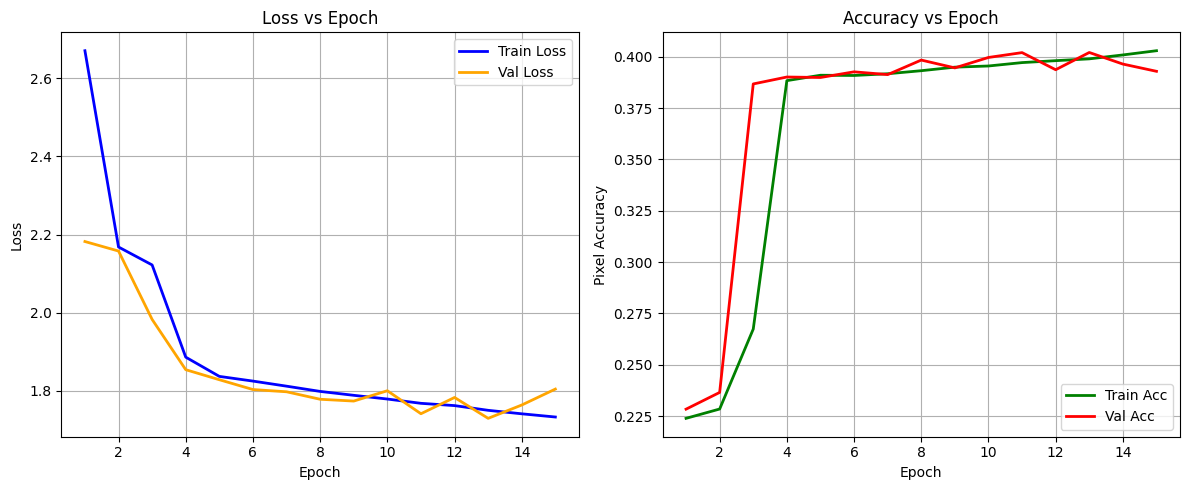

In [14]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

# ---- LOSS ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(epochs, val_losses,   label='Val Loss',   color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)

# ---- ACCURACY ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc', color='green', linewidth=2)
plt.plot(epochs, val_accuracies,   label='Val Acc',   color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

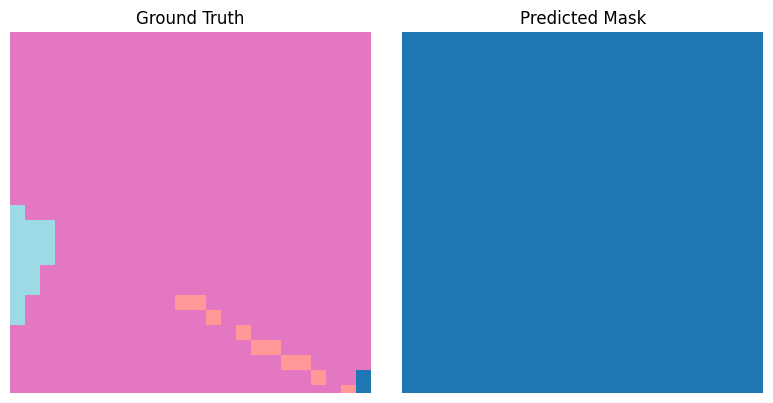

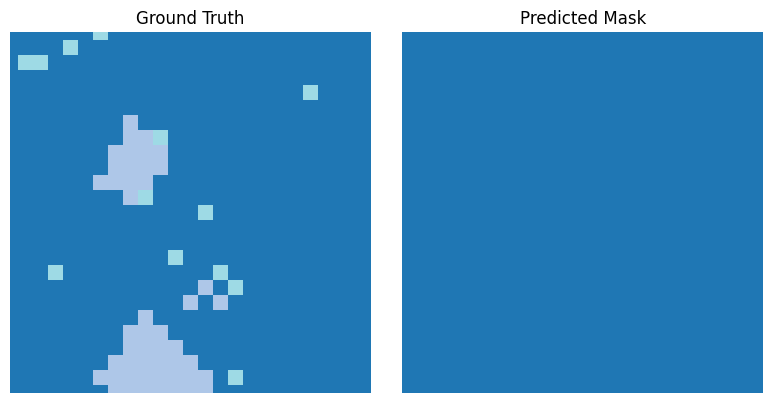

In [15]:
def visualize_prediction(model, dataset, idx=0):
    model.eval()
    x, y = dataset[idx]
    x = x.unsqueeze(0).to(DEVICE)  # Add batch dim

    with torch.no_grad():
        pred = model(x)  # (1, 20, 48, 48)
        pred_mask = pred.argmax(dim=1).squeeze().cpu()  # (48, 48)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(y, cmap='tab20')
    axs[0].set_title("Ground Truth")
    axs[1].imshow(pred_mask, cmap='tab20')
    axs[1].set_title("Predicted Mask")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Try on train and val
visualize_prediction(model, train_ds, idx=0)
visualize_prediction(model, val_ds, idx=0)

## Confusion Matrix

Confusion Matrix Evaluation: 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]
/tmp/ipykernel_36/780646844.py:22: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


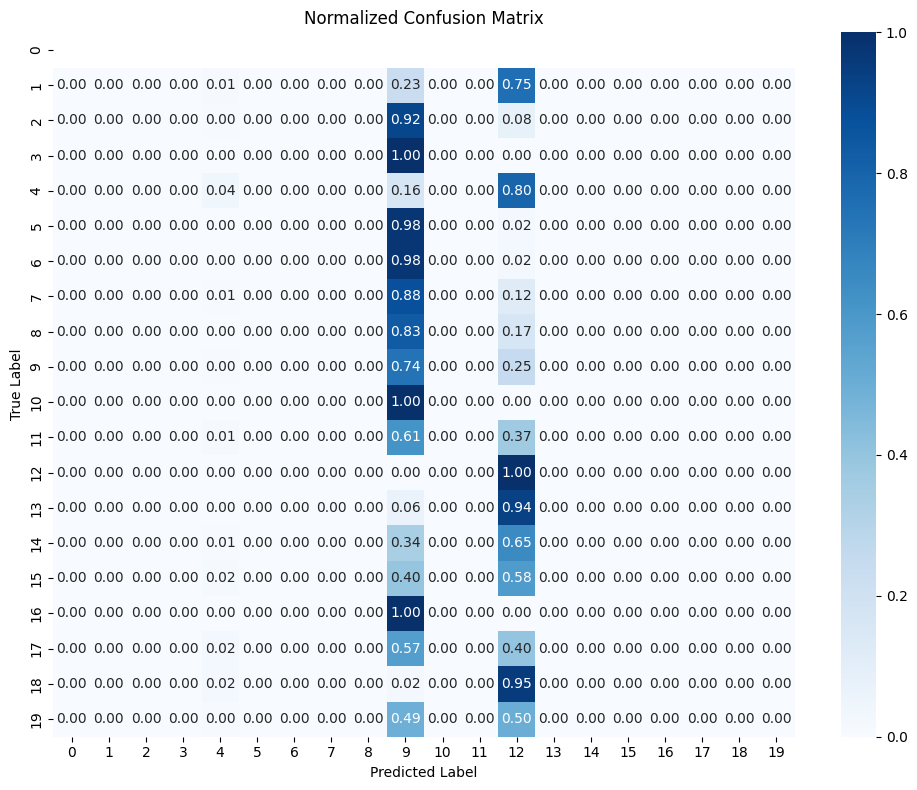

In [19]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in tqdm(val_loader, desc='Confusion Matrix Evaluation'):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)               # [B, C, H, W]
        preds = out.argmax(dim=1)    # [B, H, W]

        # Flatten predictions and labels, remove 'ignore' class (255)
        mask = (y != 255)
        all_preds.append(preds[mask].cpu().numpy())
        all_labels.append(y[mask].cpu().numpy())

# Flatten into 1D
y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_preds)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
           xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

<hr>